In [43]:
import os
import pandas as pd
import torch
import numpy as np
from cv2 import distanceTransform, DIST_L2, DIST_MASK_PRECISE
from tqdm import tqdm
from PIL import Image
import torch.utils.data as data
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

import cv2
from matplotlib import pyplot as plt

In [44]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [45]:
predPath = '../inferences/knet/test/tta/'
gtPath = '../../Dataset/Labels/'
distances = [1,3,5,10,np.inf]
nClasses = 4
maxDist = 50

In [46]:
def computeBIoUWrapper(imgFileName):
    pred = torch.from_numpy(np.array(Image.open(predPath + imgFileName))).long()
    gt = torch.from_numpy(np.array(Image.open(gtPath + imgFileName))).long()
    return computeBIoU(pred, gt)

In [47]:
def computeBIoU(pred, gt):
    BIoUs = np.zeros((maxDist, nClasses), dtype=np.float32)
    
    predOneHot = torch.nn.functional.one_hot(pred, 4).permute(2,0,1).numpy().astype(np.uint8)
    gtOneHot = torch.nn.functional.one_hot(gt, 4).permute(2,0,1).numpy().astype(np.uint8)
    distPredOneHot = np.array([cv2.distanceTransform(binImg, cv2.DIST_L2, cv2.DIST_MASK_PRECISE) for binImg in predOneHot])
    distGtOneHot = np.array([cv2.distanceTransform(binImg, cv2.DIST_L2, cv2.DIST_MASK_PRECISE) for binImg in gtOneHot])
    
    for d in range(1, maxDist+1):
        boundaryPredOneHot = np.bitwise_and(distPredOneHot <= d, predOneHot)
        boundaryGtOneHot = np.bitwise_and(distGtOneHot <= d, gtOneHot)
        # concatenate np.ones_like(boundaryPredOneHot[0]) at the end of the array to account for the background class
        boundaryPredOneHot = np.concatenate((boundaryPredOneHot, np.ones_like(boundaryPredOneHot[0])[np.newaxis]), axis=0)
        boundaryGtOneHot = np.concatenate((boundaryGtOneHot, np.ones_like(boundaryGtOneHot[0])[np.newaxis]), axis=0)
        boundaryPred = np.argmax(boundaryPredOneHot, axis=0)
        boundaryGt = np.argmax(boundaryGtOneHot, axis=0)
        
        cm = confusion_matrix(boundaryGt.flatten(), boundaryPred.flatten(), labels=np.arange(nClasses+1))
        tp = np.diag(cm)
        fp = np.sum(cm, axis=0) - tp
        fn = np.sum(cm, axis=1) - tp
        BIoUs[d-1] = (tp / (tp + fp + fn))[:nClasses]
        
    return BIoUs

In [48]:
imgFileNames = os.listdir(predPath)[:16]
with Pool(8) as p:
    BIoUs = list(tqdm(p.imap_unordered(computeBIoUWrapper, imgFileNames), total=len(imgFileNames)))
# BIoUs = np.sum(BIoUs, axis=0) / len(imgFileNames)

100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


In [49]:
BIoUs = np.mean(BIoUs, axis=0)

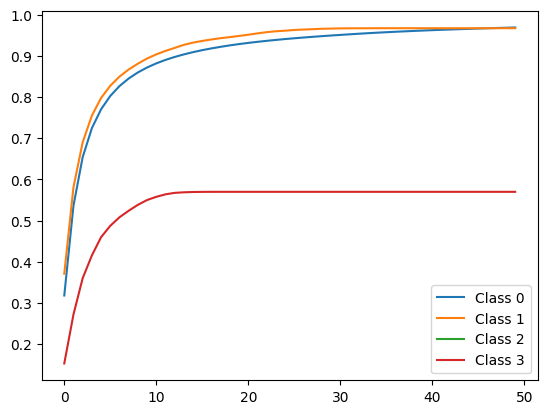

In [50]:
from matplotlib import pyplot as plt

# plot the BIoU for each class
plt.figure()
plt.plot(BIoUs[:,0], label='Class 0')
plt.plot(BIoUs[:,1], label='Class 1')
plt.plot(BIoUs[:,2], label='Class 2')
plt.plot(BIoUs[:,3], label='Class 3')
plt.legend()
plt.show()

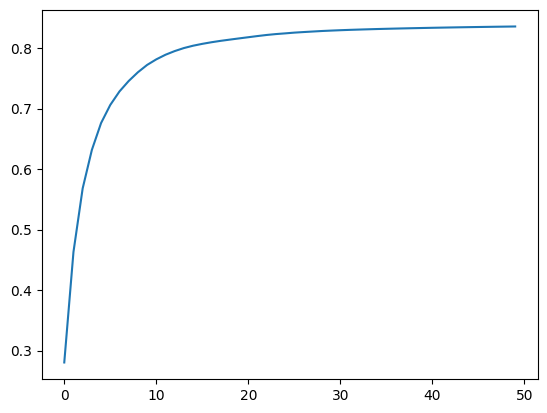

In [51]:
mBIoU = np.nanmean(BIoUs, axis=1)
plt.figure()
plt.plot(mBIoU)
plt.show()